In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas sklearn --user

In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as sk
from sklearn.model_selection import GridSearchCV

In [20]:
# Read in the csv data
train_data = pd.read_csv("train_final.csv")
test_data = pd.read_csv("test_final.csv")
# Example the contents
# print(train_data.shape)
# print(train_data.head())
print(test_data.head())

      Id      f1  f2     f3      f4  f5  f6      f7      f8  f9 ...     f15  \
0  16384   37733   1   1.77  118603   1   0  118602  118097   1 ...   13881   
1  16385  312129   1   3.54  118052   1   0  117961  290919   1 ...   14638   
2  16386   24884   1  23.01  118300   1   0  117961  302830   1 ...     770   
3  16387    4674   1   1.77  119091   1   0  119062  118036   1 ...   16752   
4  16388   68725   1   3.54  118300   1   0  117961  171056   1 ...    4945   

      f16     f17  f18     f19  f20  f21  f22  f23  f24  
0  117941  117887    1  117885    1    1    1    1    1  
1  118992  290919    1  118321    1    1    1    7    1  
2  119181    4673    1  128230    1    1    1   14    1  
3  143531  290919    1  117905    1    1    1   81    1  
4  118360  118638    1  118636    1    1    1    1    1  

[5 rows x 25 columns]


In [21]:
Y = pd.Series(train_data["Y"])
X = train_data.loc[:, "f1":"f24"]

In [ ]:
# model.predict_probability() for submission
# play with these params
params={
    'max_depth': [3, 5, 7, 9], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.4, 0.6, 0.8, .95], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5, 0.7, 0.9], #[0.5,0.6,0.7,0.8],
    'n_estimators': [100, 500, 1000, 2000], #[1000,2000,3000]
    'reg_alpha': [0.01, 0.03, 0.05], #[0.01, 0.02, 0.03, 0.04],
    'silent': [1],

}

In [32]:
import time
start_time = time.time()

# B.D.E.
A = xgb.XGBClassifier(
    n_estimators = 1000,
    max_depth = 7,
    subsample = 0.8,
    colsample_bytree = 0.7,
    reg_alpha = 0.03,
    silent = 1,
    update = 'grow_gpu',
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)

A.fit(X, Y)

print("Training one model took: " + str(time.time() - start_time), " to run")

Training one model took: 3.482536792755127  to run


In [7]:
def resultsToCsv(grid, csvname):
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='rank_test_score', inplace=True)
    results.to_csv(csvname, ',')

In [137]:
print('XGBoost with grid search')

xbgc_params = {
    'tree_method': ['gpu_hist'],
    'predictor': ['gpu_predictor'],
    'updater': ['grow_gpu'],
    'n_jobs': -1
}
xgb_clf = xgb.XGBClassifier(xbgc_params)

'''
print('Begin GridSearchCV')
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=20,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
rs.fit(X, Y)
# best_est = rs.best_estimator_
'''

XGBoost with grid search


'\nprint(\'Begin GridSearchCV\')\nrs = GridSearchCV(xgb_clf,\n                  params,\n                  cv=20,\n                  scoring="roc_auc",\n                  n_jobs=-1,\n                  verbose=False)\nrs.fit(X, Y)\n# best_est = rs.best_estimator_\n'

In [ ]:


# Grab results into csv for checking
results = pd.DataFrame(rs.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.to_csv('training_results.csv', ',')

In [22]:
X_test = test_data.loc[:, "f1":"f24"]

In [96]:
best_model = rs.best_estimator_
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=1, subsample=0.95)


In [77]:
predictions = best_model.predict_proba(X_test)
formatted_predictions = np.array(predictions)
submission = pd.DataFrame({'Id':test_data.Id, 'Y': formatted_predictions[:,1]})
submission.to_csv('submissions.csv', index=False)

In [97]:
# Okay, lets try an average of models...
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=1, subsample=0.95)


In [103]:
# Get variables from cv results, grab actual parameters

# Create 5 sets of parameters (max_depth[X,X-1,X+1], subsample +- .05, colsample +- .05,
# n_estimators ((+- half of values), reg_alpha _- .05))

# Fine tune each of the 5 for n_estimators
# Take the test values, run them through all 5 models, take an average, submit and win
model1_ftparams ={
    'colsample_bytree': [0.45, 0.5, 0.55],
    'max_depth': [8, 9, 10],  
    'n_estimators': [250, 500, 750],
    'reg_alpha': [0.005, 0.01, 0.015],
    'subsample': [0.95],
    'silent': [1],
}

ftgrid_1 = GridSearchCV(xgb_clf,
                  model1_ftparams,
                  cv=20,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
ftgrid_1.fit(X, Y)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu']},
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45, 0.5, 0.55], 'max_depth': [8, 9, 10], 'n_estimators': [250, 500, 750], 'reg_alpha': [0.005, 0.01, 0.015], 'subsample': [0.95], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [104]:
model3_ftparams ={
    'colsample_bytree': [0.45, 0.5, 0.55],
    'max_depth': [8, 9, 10],  
    'n_estimators': [500, 1000, 1500],
    'reg_alpha': [0.005, 0.01, 0.015],
    'subsample': [0.95],
    'silent': [1],
}

ftgrid_3 = GridSearchCV(xgb_clf,
                  model3_ftparams,
                  cv=20,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
ftgrid_3.fit(X, Y)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu']},
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45, 0.5, 0.55], 'max_depth': [8, 9, 10], 'n_estimators': [500, 1000, 1500], 'reg_alpha': [0.005, 0.01, 0.015], 'subsample': [0.95], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [105]:
model4_ftparams ={
    'colsample_bytree': [0.45, 0.5, 0.55],
    'max_depth': [8, 9, 10],  
    'n_estimators': [250, 500, 750],
    'reg_alpha': [0.045, 0.05, 0.055],
    'subsample': [0.95],
    'silent': [1],
}

ftgrid_4 = GridSearchCV(xgb_clf,
                  model4_ftparams,
                  cv=20,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
ftgrid_4.fit(X, Y)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu']},
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45, 0.5, 0.55], 'max_depth': [8, 9, 10], 'n_estimators': [250, 500, 750], 'reg_alpha': [0.045, 0.05, 0.055], 'subsample': [0.95], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [106]:
model8_ftparams ={
    'colsample_bytree': [0.45, 0.5, 0.55],
    'max_depth': [8, 9, 10],  
    'n_estimators': [500, 1000, 1500],
    'reg_alpha': [0.025, 0.03, 0.035],
    'subsample': [0.95],
    'silent': [1],
}

ftgrid_8 = GridSearchCV(xgb_clf,
                  model8_ftparams,
                  cv=20,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
ftgrid_8.fit(X, Y)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu']},
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45, 0.5, 0.55], 'max_depth': [8, 9, 10], 'n_estimators': [500, 1000, 1500], 'reg_alpha': [0.025, 0.03, 0.035], 'subsample': [0.95], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [ ]:
ftgrid_1_results = pd.DataFrame(ftgrid_1.cv_results_)
ftgrid_1_results.sort_values(by='rank_test_score', inplace=True)
ftgrid_1_results.to_csv('model1_ft.csv', ',')
ftgrid_3_results = pd.DataFrame(ftgrid_3.cv_results_)
ftgrid_3_results.sort_values(by='rank_test_score', inplace=True)
ftgrid_3_results.to_csv('model3_ft.csv', ',')
ftgrid_4_results = pd.DataFrame(ftgrid_4.cv_results_)
ftgrid_4_results.sort_values(by='rank_test_score', inplace=True)
ftgrid_4_results.to_csv('model4_ft.csv', ',')
ftgrid_8_results = pd.DataFrame(ftgrid_8.cv_results_)
ftgrid_8_results.sort_values(by='rank_test_score', inplace=True)
ftgrid_8_results.to_csv('model8_ft.csv', ',')

In [111]:
model1_ft_predictions = np.array(ftgrid_1.best_estimator_.predict_proba(X_test))[:,1]
model3_ft_predictions = np.array(ftgrid_3.best_estimator_.predict_proba(X_test))[:,1]
model4_ft_predictions = np.array(ftgrid_4.best_estimator_.predict_proba(X_test))[:,1]
model8_ft_predictions = np.array(ftgrid_8.best_estimator_.predict_proba(X_test))[:,1]

In [113]:
avg_ft_predictions = (model1_ft_predictions + model3_ft_predictions + model4_ft_predictions + model8_ft_predictions) / 4

In [115]:
print(avg_ft_predictions)

[0.9159833  0.97035176 0.9999771  ... 0.9998962  0.9978585  0.9926251 ]


In [116]:
submission = pd.DataFrame({'Id':test_data.Id, 'Y': avg_ft_predictions})
submission.to_csv('submissions1.csv', index=False)

In [118]:
# Okay, let's try to avoid overfitting now, calibrate learning curve
# Ref: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
xbgc_params["random_state"] = 69 # change seed
xgb_clf = xgb.XGBClassifier(xbgc_params)



In [ ]:
# Just gonna run with the best_estimator_ values... too lazy (other than n_estimators)
model1_r3_params = {
    'colsample_bytree': [0.45],
    'max_depth': [10],  
    'n_estimators': [150, 250, 350],
    'reg_alpha': [0.015],
    'subsample': [0.95],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'silent': [1],
}

r3grid_1 = GridSearchCV(xgb_clf,
                  model1_r3_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r3grid_1.fit(X, Y)

In [ ]:
model3_r3_params = {
    'colsample_bytree': [0.45],
    'max_depth': [10],  
    'n_estimators': [400, 500, 600],
    'reg_alpha': [0.015],
    'subsample': [0.95],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'silent': [1],
}

r3grid_3 = GridSearchCV(xgb_clf,
                  model3_r3_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r3grid_3.fit(X, Y)

In [ ]:
model4_r3_params = {
    'colsample_bytree': [0.45],
    'max_depth': [10],  
    'n_estimators': [150, 250, 350],
    'reg_alpha': [0.045],
    'subsample': [0.95],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'silent': [1],
}

r3grid_4 = GridSearchCV(xgb_clf,
                  model4_r3_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r3grid_4.fit(X, Y)

In [ ]:
model8_r3_params = {
    'colsample_bytree': [0.45],
    'max_depth': [10],  
    'n_estimators': [400, 500, 600],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'silent': [1],
}

r3grid_8 = GridSearchCV(xgb_clf,
                  model8_r3_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r3grid_8.fit(X, Y)

In [ ]:
r3grid_1_results = pd.DataFrame(r3grid_1.cv_results_)
r3grid_1_results.sort_values(by='rank_test_score', inplace=True)
r3grid_1_results.to_csv('model1_r3.csv', ',')
r3grid_3_results = pd.DataFrame(r3grid_3.cv_results_)
r3grid_3_results.sort_values(by='rank_test_score', inplace=True)
r3grid_3_results.to_csv('model3_r3.csv', ',')
r3grid_4_results = pd.DataFrame(r3grid_4.cv_results_)
r3grid_4_results.sort_values(by='rank_test_score', inplace=True)
r3grid_4_results.to_csv('model4_r3.csv', ',')
r3grid_8_results = pd.DataFrame(r3grid_8.cv_results_)
r3grid_8_results.sort_values(by='rank_test_score', inplace=True)
r3grid_8_results.to_csv('model8_r3.csv', ',')

In [129]:
model1_r3_predictions = np.array(r3grid_1.best_estimator_.predict_proba(X_test))[:,1]
model3_r3_predictions = np.array(r3grid_3.best_estimator_.predict_proba(X_test))[:,1]
model4_r3_predictions = np.array(r3grid_4.best_estimator_.predict_proba(X_test))[:,1]
model8_r3_predictions = np.array(r3grid_8.best_estimator_.predict_proba(X_test))[:,1]

In [130]:
avg_r3_predictions = (model1_r3_predictions + model3_r3_predictions + model4_r3_predictions + model8_r3_predictions) / 4

In [131]:
submission = pd.DataFrame({'Id':test_data.Id, 'Y': avg_r3_predictions})
submission.to_csv('submissions2.csv', index=False)

In [138]:
# Okay lets just optimize one model with various values we can go off of
xbgc_params["random_state"] = 42 # change seed
xgb_clf = xgb.XGBClassifier(xbgc_params)

model8_r4_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.2, 0.4, 0.6, 0.8],
    'min_child_weight': [2, 4, 6, 8],
    'max_depth': [6, 8, 10],  
    'n_estimators': [250, 500, 750],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.001, 0.005, 0.01],
    'silent': [1],
}

r4grid_8 = GridSearchCV(xgb_clf,
                  model8_r4_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r4grid_8.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 42},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.2, 0.4, 0.6, 0.8], 'min_child_weight': [2, 4, 6, 8], 'max_depth': [6, 8, 10], 'n_estimators': [250, 500, 750], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.001, 0.005, 0.01], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [140]:
r4grid_8_results = pd.DataFrame(r4grid_8.cv_results_)
r4grid_8_results.sort_values(by='rank_test_score', inplace=True)
r4grid_8_results.to_csv('model8_r4.csv', ',')

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [141]:
model8_r4_predictions = np.array(r4grid_8.best_estimator_.predict_proba(X_test))[:,1]

In [142]:
submission = pd.DataFrame({'Id':test_data.Id, 'Y': model8_r4_predictions})
submission.to_csv('submissionsr4.csv', index=False)

In [143]:
# LOOKS like we fixed overfitting now to improve further...

In [148]:
xbgc_params["random_state"] = 27 # change seed
xgb_clf = xgb.XGBClassifier(xbgc_params)

m1_r5_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.3],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [400, 500, 600],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.001, 0.005, 0.01],
    'silent': [1],
}

r5grid_m1 = GridSearchCV(xgb_clf,
                  m1_r5_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r5grid_m1.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.3], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [400, 500, 600], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.001, 0.005, 0.01], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [149]:
m2_r5_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.4],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [400, 500, 600],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.001, 0.005, 0.01],
    'silent': [1],
}

r5grid_m2 = GridSearchCV(xgb_clf,
                  m2_r5_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r5grid_m2.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.4], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [400, 500, 600], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.001, 0.005, 0.01], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [150]:
m3_r5_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.6],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [400, 500, 600],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.0005, 0.001, 0.005],
    'silent': [1],
}

r5grid_m3 = GridSearchCV(xgb_clf,
                  m3_r5_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r5grid_m3.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.6], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [400, 500, 600], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.0005, 0.001, 0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [151]:
m4_r5_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.4],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [650, 750, 850],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.0005, 0.001, 0.005],
    'silent': [1],
}

r5grid_m4 = GridSearchCV(xgb_clf,
                  m4_r5_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r5grid_m4.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.4], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [650, 750, 850], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.0005, 0.001, 0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [152]:
m7_r5_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.6],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [650, 750, 850],
    'reg_alpha': [0.025],
    'subsample': [0.95],
    'learning_rate': [0.0005, 0.001, 0.005],
    'silent': [1],
}

r5grid_m7 = GridSearchCV(xgb_clf,
                  m7_r5_params,
                  cv=25,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r5grid_m7.fit(X, Y)

GridSearchCV(cv=25, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.6], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [650, 750, 850], 'reg_alpha': [0.025], 'subsample': [0.95], 'learning_rate': [0.0005, 0.001, 0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [156]:
resultsToCsv(r5grid_m1, "r5_m1.csv")
resultsToCsv(r5grid_m2, "r5_m2.csv")
resultsToCsv(r5grid_m3, "r5_m3.csv")
resultsToCsv(r5grid_m4, "r5_m4.csv")
resultsToCsv(r5grid_m7, "r5_m7.csv")

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [158]:
# Note to self: maybe lets improve by using larger n_estimators and dropping learning rate later?

In [160]:
m7_r6_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.5, 0.6, 0.7],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [850],
    'reg_alpha': [0.02, 0.025, 0.03],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r6grid_m7 = GridSearchCV(xgb_clf,
                  m7_r6_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r6grid_m7.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.5, 0.6, 0.7], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [850], 'reg_alpha': [0.02, 0.025, 0.03], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [161]:
m4_r6_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.3, 0.4, 0.5],
    'min_child_weight': [2],
    'max_depth': [10],  
    'n_estimators': [850],
    'reg_alpha': [0.02, 0.025, 0.03],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r6grid_m4 = GridSearchCV(xgb_clf,
                  m4_r6_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r6grid_m4.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.3, 0.4, 0.5], 'min_child_weight': [2], 'max_depth': [10], 'n_estimators': [850], 'reg_alpha': [0.02, 0.025, 0.03], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [162]:
resultsToCsv(r6grid_m4, "r6_m4.csv")
resultsToCsv(r6grid_m7, "r6_m7.csv")

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [163]:
m4_r7_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.3],
    'min_child_weight': [1,2,3],
    'max_depth': [9,10],  
    'n_estimators': [850],
    'reg_alpha': [0.03],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r7grid_m4 = GridSearchCV(xgb_clf,
                  m4_r7_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r7grid_m4.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.3], 'min_child_weight': [1, 2, 3], 'max_depth': [9, 10], 'n_estimators': [850], 'reg_alpha': [0.03], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [164]:
m7_r7_params = {
    'colsample_bytree': [0.45],
    'gamma': [0.6],
    'min_child_weight': [1,2,3],
    'max_depth': [9,10],  
    'n_estimators': [850],
    'reg_alpha': [0.02],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r7grid_m7 = GridSearchCV(xgb_clf,
                  m7_r7_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r7grid_m7.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.45], 'gamma': [0.6], 'min_child_weight': [1, 2, 3], 'max_depth': [9, 10], 'n_estimators': [850], 'reg_alpha': [0.02], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [166]:
resultsToCsv(r7grid_m4, "r7_m4.csv")
resultsToCsv(r7grid_m7, "r7_m7.csv")

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [167]:
r7_m4_predictions = np.array(r7grid_m4.best_estimator_.predict_proba(X_test))[:,1]
r7_m7_predictions = np.array(r7grid_m7.best_estimator_.predict_proba(X_test))[:,1]

In [169]:
r7_predictions = (r7_m4_predictions + r7_m7_predictions) / 2
submission = pd.DataFrame({'Id':test_data.Id, 'Y': r7_predictions})
submission.to_csv('submissionsr7.csv', index=False)

In [170]:
m4_r8_params = {
    'colsample_bytree': [0.4, 0.45, 0.5],
    'gamma': [0.3],
    'min_child_weight': [1],
    'max_depth': [10],  
    'n_estimators': [850],
    'reg_alpha': [0.03],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r8grid_m4 = GridSearchCV(xgb_clf,
                  m4_r8_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r8grid_m4.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.4, 0.45, 0.5], 'gamma': [0.3], 'min_child_weight': [1], 'max_depth': [10], 'n_estimators': [850], 'reg_alpha': [0.03], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [171]:
m7_r8_params = {
    'colsample_bytree': [0.4, 0.45, 0.5],
    'gamma': [0.6],
    'min_child_weight': [1],
    'max_depth': [10],  
    'n_estimators': [850],
    'reg_alpha': [0.03],
    'subsample': [0.95],
    'learning_rate': [0.005],
    'silent': [1],
}

r8grid_m7 = GridSearchCV(xgb_clf,
                  m7_r8_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r8grid_m7.fit(X, Y)

GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'tree_method': ['gpu_hist'], 'predictor': ['gpu_predictor'], 'updater': ['grow_gpu'], 'n_jobs': -1, 'random_state': 27},
       mi...0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.4, 0.45, 0.5], 'gamma': [0.6], 'min_child_weight': [1], 'max_depth': [10], 'n_estimators': [850], 'reg_alpha': [0.03], 'subsample': [0.95], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [175]:
resultsToCsv(r8grid_m4, "r8_m4.csv")
resultsToCsv(r8grid_m7, "r8_m7.csv")
r8_m4_predictions = np.array(r8grid_m4.best_estimator_.predict_proba(X_test))[:,1]
r8_m7_predictions = np.array(r8grid_m7.best_estimator_.predict_proba(X_test))[:,1]
r8_predictions = (r8_m4_predictions + r8_m7_predictions) / 2
submission = pd.DataFrame({'Id':test_data.Id, 'Y': r8_predictions})
submission.to_csv('submissionsr8.csv', index=False)

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [174]:
print(r8grid_m4.best_estimator_)
print(r8grid_m7.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.3, learning_rate=0.005,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=850, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.03,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.95)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.6, learning_rate=0.005,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=850, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.03,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.95)


In [186]:
# Lets fine tune gamma and reg_alpha
xbgc_params = {
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'random_state': 69
}
xgb_clf = xgb.XGBClassifier(
    **xbgc_params
)
print(xgb_clf)
r9_m7_params = {
    'colsample_bytree': [0.4],
    'gamma': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1],
    'max_depth': [10],
    'n_estimators': [850],
    'reg_alpha': [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'learning_rate': [0.005],
    'silent': [1]
}

r9grid_m7 = GridSearchCV(xgb_clf,
                  r9_m7_params,
                  cv=30,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
r9grid_m7.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=69, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')


GridSearchCV(cv=30, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=69, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'colsample_bytree': [0.4], 'gamma': [0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [1], 'max_depth': [10], 'n_estimators': [850], 'reg_alpha': [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'learning_rate': [0.005], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=False)

In [187]:
resultsToCsv(r9grid_m7, "r9_m7.csv")

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [189]:
r9_m7_predictions = np.array(r9grid_m7.best_estimator_.predict_proba(X_test))[:,1]
submission = pd.DataFrame({'Id':test_data.Id, 'Y': r9_m7_predictions})
submission.to_csv('submissionsr9.csv', index=False)

In [17]:
# B.D.E.
train_data = pd.read_csv("train_final.csv")
test_data = pd.read_csv("test_final.csv")
Y = pd.Series(train_data["Y"])
X = train_data.loc[:, "f1":"f24"]
X_test = test_data.loc[:, "f1":"f24"]

import time
start_time = time.time()
BDE = xgb.XGBClassifier(
    n_estimators = 30000,
    max_depth = 10,
    subsample = .95,
    colsample_bytree = 0.4,
    gamma = 0.9,
    min_child_weight = 1,
    reg_alpha = 0.07,
    learning_rate = 0.0005,
    silent = 1,
    update = 'grow_gpu',
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)

BDE.fit(X, Y)
print("Training one model took: " + str(time.time() - start_time), " to run")

Training one model took: 273.1570289134979  to run


In [23]:
predictions = np.array(BDE.predict_proba(X_test))[:,1]
submission = pd.DataFrame({'Id':test_data.Id, 'Y': predictions})
submission.to_csv('submissionsBDE1.csv', index=False)

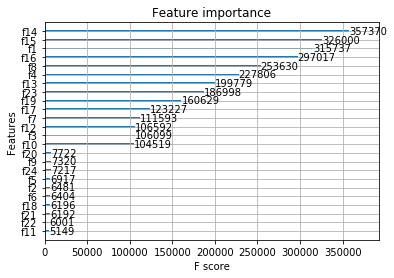

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [29]:
from matplotlib import pyplot
xgb.plot_importance(BDE)
pyplot.show()

In [94]:
# Lets fine tune gamma and reg_alpha
train_data = pd.read_csv("train_final.csv").drop(columns=["f2", "f5", "f6", "f9", "f10", "f11", "f12", "f18", "f20",
                                                          "f21", "f22", "f24",
                                                          "f3"
                                                         ])
Y = pd.Series(train_data["Y"])
X = train_data.loc[:, "f1":"f23"]
X_test = test_data.loc[:, "f1":"f24"]

xbgc_params = {
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'random_state': 69
}
xgb_clf = xgb.XGBClassifier(
    **xbgc_params
)

lde_params = {
    'colsample_bytree': [0.4],
    'gamma': [0.9],
    'min_child_weight': [1],
    'max_depth': [10],
    'n_estimators': [50000],
    'reg_alpha': [0.07],
    'learning_rate': [0.0001],
    'subsample': [0.95],
    'silent': [1]
}

lde_grid = GridSearchCV(xgb_clf,
                  lde_params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=False)
lde_grid.fit(X, Y)
resultsToCsv(lde_grid, "lde_results.csv")

/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vod/.local/lib/python3.7/site-packages/skle

In [96]:
test_data = pd.read_csv("test_final.csv").drop(columns=["f2", "f5", "f6", "f9", "f10", "f11", "f12", "f18", "f20",
                                                          "f21", "f22", "f24",
                                                          "f3"
                                                         ])
X_test = test_data.loc[:, "f1":"f23"]
predictions = np.array(lde_grid.best_estimator_.predict_proba(X_test))[:,1]
submission = pd.DataFrame({'Id':test_data.Id, 'Y': predictions})
submission.to_csv('submissionsLDE.csv', index=False)

In [116]:
bde_fine = xgb.XGBClassifier(
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor',
    random_state = 69,
    colsample_bytree = 0.4,
    gamma = 0.9,
    min_child_weight= 1,
    max_depth = 10,
    n_estimators = 80000,
    reg_alpha = 0.07,
    learning_rate =  0.000001,
    subsample = 0.95,
    n_jobs = -1,
    silent = 1
)

bde_fine.fit(X, Y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.9, learning_rate=1e-06,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=80000, n_jobs=-1, nthread=None,
       objective='binary:logistic', predictor='gpu_predictor',
       random_state=69, reg_alpha=0.07, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.95, tree_method='gpu_hist')

In [122]:
test_data = pd.read_csv("test_final.csv").drop(columns=["f2", "f5", "f6", "f9", "f10", "f11", "f12", "f18", "f20",
                                                          "f21", "f22", "f24",
                                                          "f3"
                                                         ])
X_test = test_data.loc[:, "f1":"f23"]
predictions = np.array(bde_fine.predict_proba(X_test))[:,1]
submission = pd.DataFrame({'Id':test_data.Id, 'Y': predictions})
submission.to_csv('submissionsLast.csv', index=False)

In [109]:
bde_fine.predict_proba(X_test)

array([[0.46756518, 0.5324348 ],
       [0.4711544 , 0.5288456 ],
       [0.4641133 , 0.5358867 ],
       ...,
       [0.46411204, 0.53588796],
       [0.4660473 , 0.5339527 ],
       [0.46578205, 0.53421795]], dtype=float32)